In [1]:
import torch 
import numpy as np
from pathlib import Path 
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm 
import matplotlib.colors as colors
from transformers.models.llama.modeling_llama import repeat_kv
from src.models import load_model_tokenizer, get_layers_heads
from src.model_wrapper import ModelWrapper
from src.to_numpy import to_numpy

/data/tianyu/miniconda3/envs/dormant/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/tianyu/miniconda3/envs/dormant/lib/python3.12/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
from src.hook import Hook, RecordHook, ZeroOutAttentionHeadHook, CompositeHook
import os

In [3]:
dir_path = "/data/tianyu/DormantHeads/figures/new"

In [4]:
device = "cuda:0"

In [5]:
model_name = "llama3.1-8B"
model, tokenizer = load_model_tokenizer(model_name, device_map=device)
num_layers, num_heads = get_layers_heads(model_name)
wrapper = ModelWrapper(model)

Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


In [6]:
text = "Summer is warm. Winter is cold."
inputs = tokenizer(text, return_tensors="pt").input_ids.to(device)
print(inputs)
print(tokenizer.decode(inputs.cpu().tolist()[0], clean_up_tokenization_spaces=False))
tokens = tokenizer.convert_ids_to_tokens(inputs.cpu().tolist()[0])
print(tokens)
tokens[0] = r"$\langle s \rangle$"
tokens = list(map(lambda x: x.replace("Ġ", " "), tokens))
token_labels = tokens
tokens = list(map(lambda x: str(x[0]) + x[1], enumerate(tokens)))
print(tokens)
print(token_labels)
token_colors = ["navy", "black", "black", "black", "black", "black", "black", "black", "black"]
token_colors_boxenplot= ["paleturquoise", "lightgray", "lightgray", "lightgray", "lightgray", "lightgray", "lightgray", "lightgray", "lightgray"]
token_colors_plots= ["royalblue", "darkslategray", "darkslategray", "darkslategray", "darkslategray", "darkslategray", "darkslategray", "darkslategray", "darkslategray"]

tensor([[128000,  51787,    374,   8369,     13,  20704,    374,   9439,     13]],
       device='cuda:0')
<|begin_of_text|>Summer is warm. Winter is cold.
['<|begin_of_text|>', 'Summer', 'Ġis', 'Ġwarm', '.', 'ĠWinter', 'Ġis', 'Ġcold', '.']
['0$\\langle s \\rangle$', '1Summer', '2 is', '3 warm', '4.', '5 Winter', '6 is', '7 cold', '8.']
['$\\langle s \\rangle$', 'Summer', ' is', ' warm', '.', ' Winter', ' is', ' cold', '.']


In [7]:
def collect_statistics(inputs, layer):
    layer_input_prenorm_hook = RecordHook(target_name="layer_input_prenorm", record_buffer=[], target_layers=[layer])
    layer_input_postnorm_hook = RecordHook(target_name="layer_input_postnorm", record_buffer=[], target_layers=[layer])
    q_hook = RecordHook(target_name="q_proj", record_buffer=[], target_layers=[layer])
    k_hook = RecordHook(target_name="k_proj", record_buffer=[], target_layers=[layer])
    v_hook = RecordHook(target_name="v_proj", record_buffer=[], target_layers=[layer])
    q_postrope_hook = RecordHook(target_name="q_proj_postrope", record_buffer=[], target_layers=[layer])
    k_postrope_hook = RecordHook(target_name="k_proj_postrope", record_buffer=[], target_layers=[layer])
    v_postrope_hook = RecordHook(target_name="v_proj_postrope", record_buffer=[], target_layers=[layer])
    attn_logits_hook = RecordHook(target_name="attn_logits", record_buffer=[], target_layers=[layer])
    attn_weights_hook = RecordHook(target_name="attn_weights", record_buffer=[], target_layers=[layer])
    attn_softmax_qkt_v_hook = RecordHook(target_name="attn_softmax_qkt_v", record_buffer=[], target_layers=[layer])
    attn_output_hook = RecordHook(target_name="attn_output", record_buffer=[], target_layers=[layer])
    post_attn_residual_hook = RecordHook(target_name="post_attn_residual", record_buffer=[], target_layers=[layer])
    post_attn_postnorm_hook = RecordHook(target_name="post_attn_postnorm", record_buffer=[], target_layers=[layer])
    post_mlp_residual_hook = RecordHook(target_name="post_mlp_residual", record_buffer=[], target_layers=[layer])
    hook = CompositeHook(hooks=[layer_input_prenorm_hook, layer_input_postnorm_hook, q_hook, k_hook, v_hook, q_postrope_hook, k_postrope_hook, v_postrope_hook, attn_logits_hook, attn_weights_hook, attn_softmax_qkt_v_hook, attn_output_hook, post_attn_residual_hook, post_attn_postnorm_hook, post_mlp_residual_hook])
    _ = wrapper.forward(inputs, hook=hook)
    stats = {
        "layer_input_prenorm": layer_input_prenorm_hook.record_buffer[0],
        "layer_input_postnorm": layer_input_postnorm_hook.record_buffer[0],
        "q": q_hook.record_buffer[0],
        "k": k_hook.record_buffer[0],
        "v": v_hook.record_buffer[0],
        "q_postrope": q_postrope_hook.record_buffer[0],
        "k_postrope": k_postrope_hook.record_buffer[0],
        "v_postrope": v_postrope_hook.record_buffer[0],
        "attn_logits": attn_logits_hook.record_buffer[0],
        "attn_weights": attn_weights_hook.record_buffer[0],
        "attn_softmax_qkt_v": attn_softmax_qkt_v_hook.record_buffer[0],
        "attn_output": attn_output_hook.record_buffer[0],
        "post_attn_residual": post_attn_residual_hook.record_buffer[0],
        "post_attn_postnorm": post_attn_postnorm_hook.record_buffer[0],
        "post_mlp_residual": post_mlp_residual_hook.record_buffer[0],
    }
    return stats

In [8]:
def plot_attn_weights(attn_weights, layer_probe, num_heads):
    # Extract the attention weights tensor from the hook's record buffer
    attn_weights = to_numpy(attn_weights)

    # Visualize each slice in the index 1 as a separate seaborn heatmap
    num_heads = attn_weights.shape[0]
    assert num_heads == 32
    rows, cols = 4, 8
    fig, axes = plt.subplots(rows, cols, figsize=(20, 8))
    axes = axes.flatten()

    for head in range(num_heads):
        sns.heatmap(attn_weights[head], cmap="Blues", ax=axes[head], mask=attn_weights[head] == 0)
        axes[head].set_title(f"L{layer_probe}H{head}")
        axes[head].set_xlabel("K")
        axes[head].set_ylabel("Q")

    plt.tight_layout()
    plt.show()



### Step 0: Exhibit attention sink and massive norm in Llama 3.1 8B.

In [9]:
layer_probe = 24
stats = collect_statistics(inputs, layer_probe)

We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/internal/generation_utils#transformers.Cache)
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


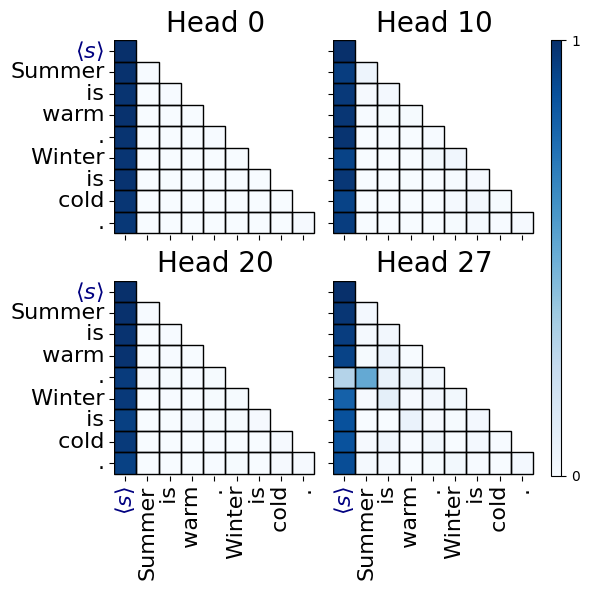

In [10]:
attn_weights = to_numpy(stats["attn_weights"][0])

heads_to_plot = [0, 10, 20, 27,]

fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 0.05])
axes = [fig.add_subplot(gs[i, j]) for i in range(2) for j in range(2)]

for head_idx, ax in zip(heads_to_plot, axes):
    sns.heatmap(attn_weights[head_idx], cmap="Blues", ax=ax, mask=attn_weights[head_idx] == 0, cbar=False)
    ax.set_title(f"Head {head_idx}", fontsize=20)

    if head_idx == 0 or head_idx == 20:
        ax.set_yticklabels(token_labels)
        ax.tick_params(axis='y', labelrotation=0, labelsize=16)
    else:
        ax.set_yticklabels([])

    if head_idx == 20 or head_idx == 27:
        ax.set_xticklabels(token_labels)
        ax.tick_params(axis='x', labelrotation=90, labelsize=16)
    else:
        ax.set_xticklabels([])

    for xtick, color in zip(ax.get_xticklabels(), token_colors):
        xtick.set_color(color)
    for ytick, color in zip(ax.get_yticklabels(), token_colors):
        ytick.set_color(color)
    
    for i in range(len(attn_weights[head_idx])):
            for j in range(i+1):
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='black', lw=1))
        
    ax.set_ylim(len(attn_weights[head_idx])+0.1, 0)
    ax.set_xlim(0, len(attn_weights[head_idx])+0.1)

cbar_ax = fig.add_subplot(gs[:, -1])

norm = colors.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap="Blues", norm=norm)
sm.set_array([])
fig.colorbar(sm, cax=cbar_ax, ticks=[0, 1])

fig.savefig(os.path.join(dir_path, "demo_attn_sink.pdf"), dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

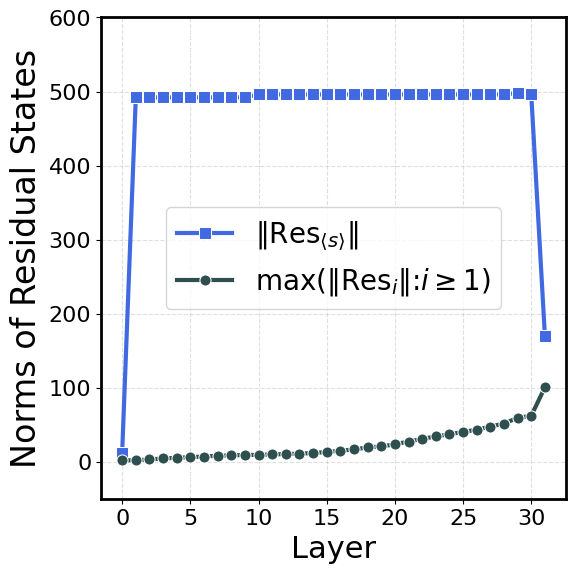

In [11]:
fig = plt.figure(figsize=(6, 6.25))
ax = fig.add_subplot(1, 1, 1)
lw = 3
ms = 8
ax.grid(alpha=0.4, linestyle='--')
for x in ax.spines.values():
    x.set_linewidth(2)


layerwise_token_norms = []
for layer in range(num_layers):
    layer_stats = collect_statistics(inputs, layer)
    layerwise_token_norms.append(torch.linalg.norm(layer_stats["post_mlp_residual"], dim=-1))
layerwise_token_norms = torch.stack(layerwise_token_norms, dim=0)  # (L, B, N)
layerwise_bos_norms = layerwise_token_norms[:, :, 0]  # (L, B)

df = pd.DataFrame({"Layer": list(range(num_layers)), "Norm": to_numpy(tensor=layerwise_bos_norms).tolist()}).explode("Norm")
sns.lineplot(x="Layer", y="Norm", data=df, label=r"$\|$" + r"$\text{Res}_{\langle s \rangle}$" + r"$\|$", marker="s", color=token_colors_plots[0], linewidth=lw, markersize=ms)

layerwise_max_non_bos_norms = torch.max(layerwise_token_norms[:, :, 1:], dim=-1).values

df = pd.DataFrame({"Layer": list(range(num_layers)), "Norm": to_numpy(tensor=layerwise_max_non_bos_norms).tolist()}).explode("Norm")
lineplot = sns.lineplot(x="Layer", y="Norm", data=df, label=r"$\max(\|" + r"\text{Res}_{i}" + r"\| \colon i \geq 1)$", marker="o", color=token_colors_plots[1], linewidth=lw, markersize=ms)

for spine in lineplot.spines.values():
    spine.set_linewidth(2) 

plt.ylim(-50, 600)
plt.ylabel("Norms of Residual States", fontsize=24)
plt.xlabel("Layer", fontsize=22)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# #plt.title("Residual Stream Token Norms", fontsize=20)
plt.legend(fontsize=20)
fig.savefig(os.path.join(dir_path, "demo_res_peak.pdf"), dpi=300, bbox_inches='tight')
plt.show()


/tmp/ipykernel_476043/1483130502.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxenplot = sns.boxenplot(data=df, x="Token", y="Value State Norms", palette=token_colors_boxenplot, showfliers=True, flier_kws=dict(marker='v', c='black', s=6,), linewidth=1.5)


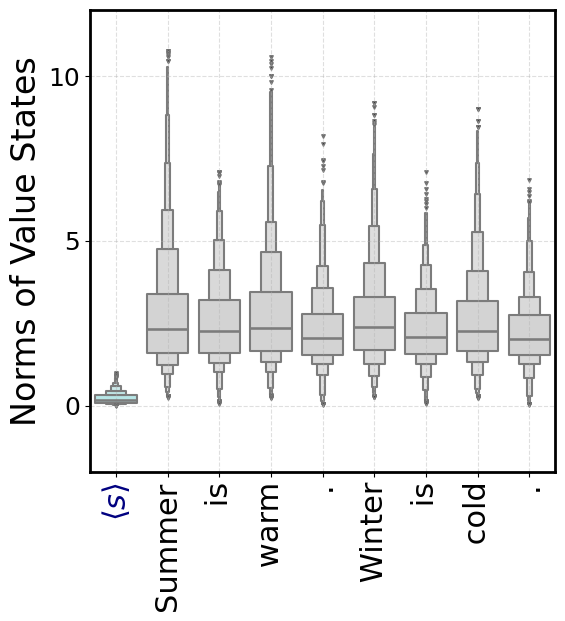

In [12]:
from torch.nn import functional as F
layerwise_value_state_norms = []
for layer in range(num_layers):
    stats = collect_statistics(inputs, layer)
    attn = model.model.layers[layer].self_attn
    values = stats["v_postrope"]
    o_split = attn.o_proj.weight.split(attn.head_dim, dim=1)
    vo_head = torch.stack([F.linear(values[0:1, i, ...], o_split[i]) for i in range(num_heads)], dim=1)
    tmp = torch.linalg.norm(vo_head, dim=-1) # (B, H, N)
    layerwise_value_state_norms.append(tmp)
layerwise_value_state_norms = torch.stack(layerwise_value_state_norms, dim=0)  # (L, B, H, N)
def remove_outliers(tmp):
    tmp = tmp.float()  # (L, B, H, N)
    for i in range(tmp.shape[-1]):
        q1 = torch.quantile(tmp[:, :, :, i], 0.01)
        q99 = torch.quantile(tmp[:, :, :, i], 0.99)
        mask = (tmp[:, :, :, i] < q1) | (tmp[:, :, :, i] > q99)
        tmp[:, :, :, i][mask] = float('nan')
    return tmp

layerwise_value_state_norms = remove_outliers(layerwise_value_state_norms)


fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.grid(alpha=0.4, linestyle='--')
for x in ax.spines.values():
    x.set_linewidth(2)

value_state_norms = to_numpy(tensor=layerwise_value_state_norms.transpose(0, 3).flatten(1, 3))  # (N, B * H * L)
df = pd.DataFrame({"Token": list(map(lambda x: str(x[0]) + x[1], enumerate(tokens))), "Value State Norms": value_state_norms.tolist()}).explode("Value State Norms")
df = df.reset_index(drop=True)

boxenplot = sns.boxenplot(data=df, x="Token", y="Value State Norms", palette=token_colors_boxenplot, showfliers=True, flier_kws=dict(marker='v', c='black', s=6,), linewidth=1.5)
boxenplot.set_xticks(range(len(token_labels)))
boxenplot.grid(alpha=0.4, linestyle='--')
plt.xticks(rotation=90, fontsize=22)
plt.yticks([0, 5, 10, 15], fontsize=18)
plt.ylim(-2, 12)
boxenplot.set_xticklabels(token_labels)
for spine in boxenplot.spines.values():
    spine.set_linewidth(2)  

for xtick, color in zip(boxenplot.get_xticklabels(), token_colors):
    xtick.set_color(color)
plt.xlabel("")
plt.ylabel('Norms of Value States', fontsize=24)
fig.savefig(os.path.join(dir_path, "demo_val_drain.pdf"), dpi=300, bbox_inches='tight')
plt.show()

### Step 1: Find the first layer where attention sink manifests

In [13]:
def plot_feature_norms(features, layer_probe):
    norms = torch.linalg.norm(features, dim=-1)
    norms = to_numpy(norms)
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=norms)
    plt.legend()
    plt.xlabel('Token')
    plt.ylabel('Norm')
    plt.title(f'Norms of Features at Layer {layer_probe}')
    plt.show()


In [14]:
batch_idx = 0
trial = 0

In [15]:
layer_probe = 0
stats = collect_statistics(inputs, layer_probe)

In [16]:
batch_size, num_tokens, feature_dim = stats["layer_input_postnorm"].shape
num_heads, head_dim = stats["q"].shape[1], stats["q"].shape[3]
assert num_tokens == stats["q"].shape[2]

/tmp/ipykernel_476043/1304506844.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


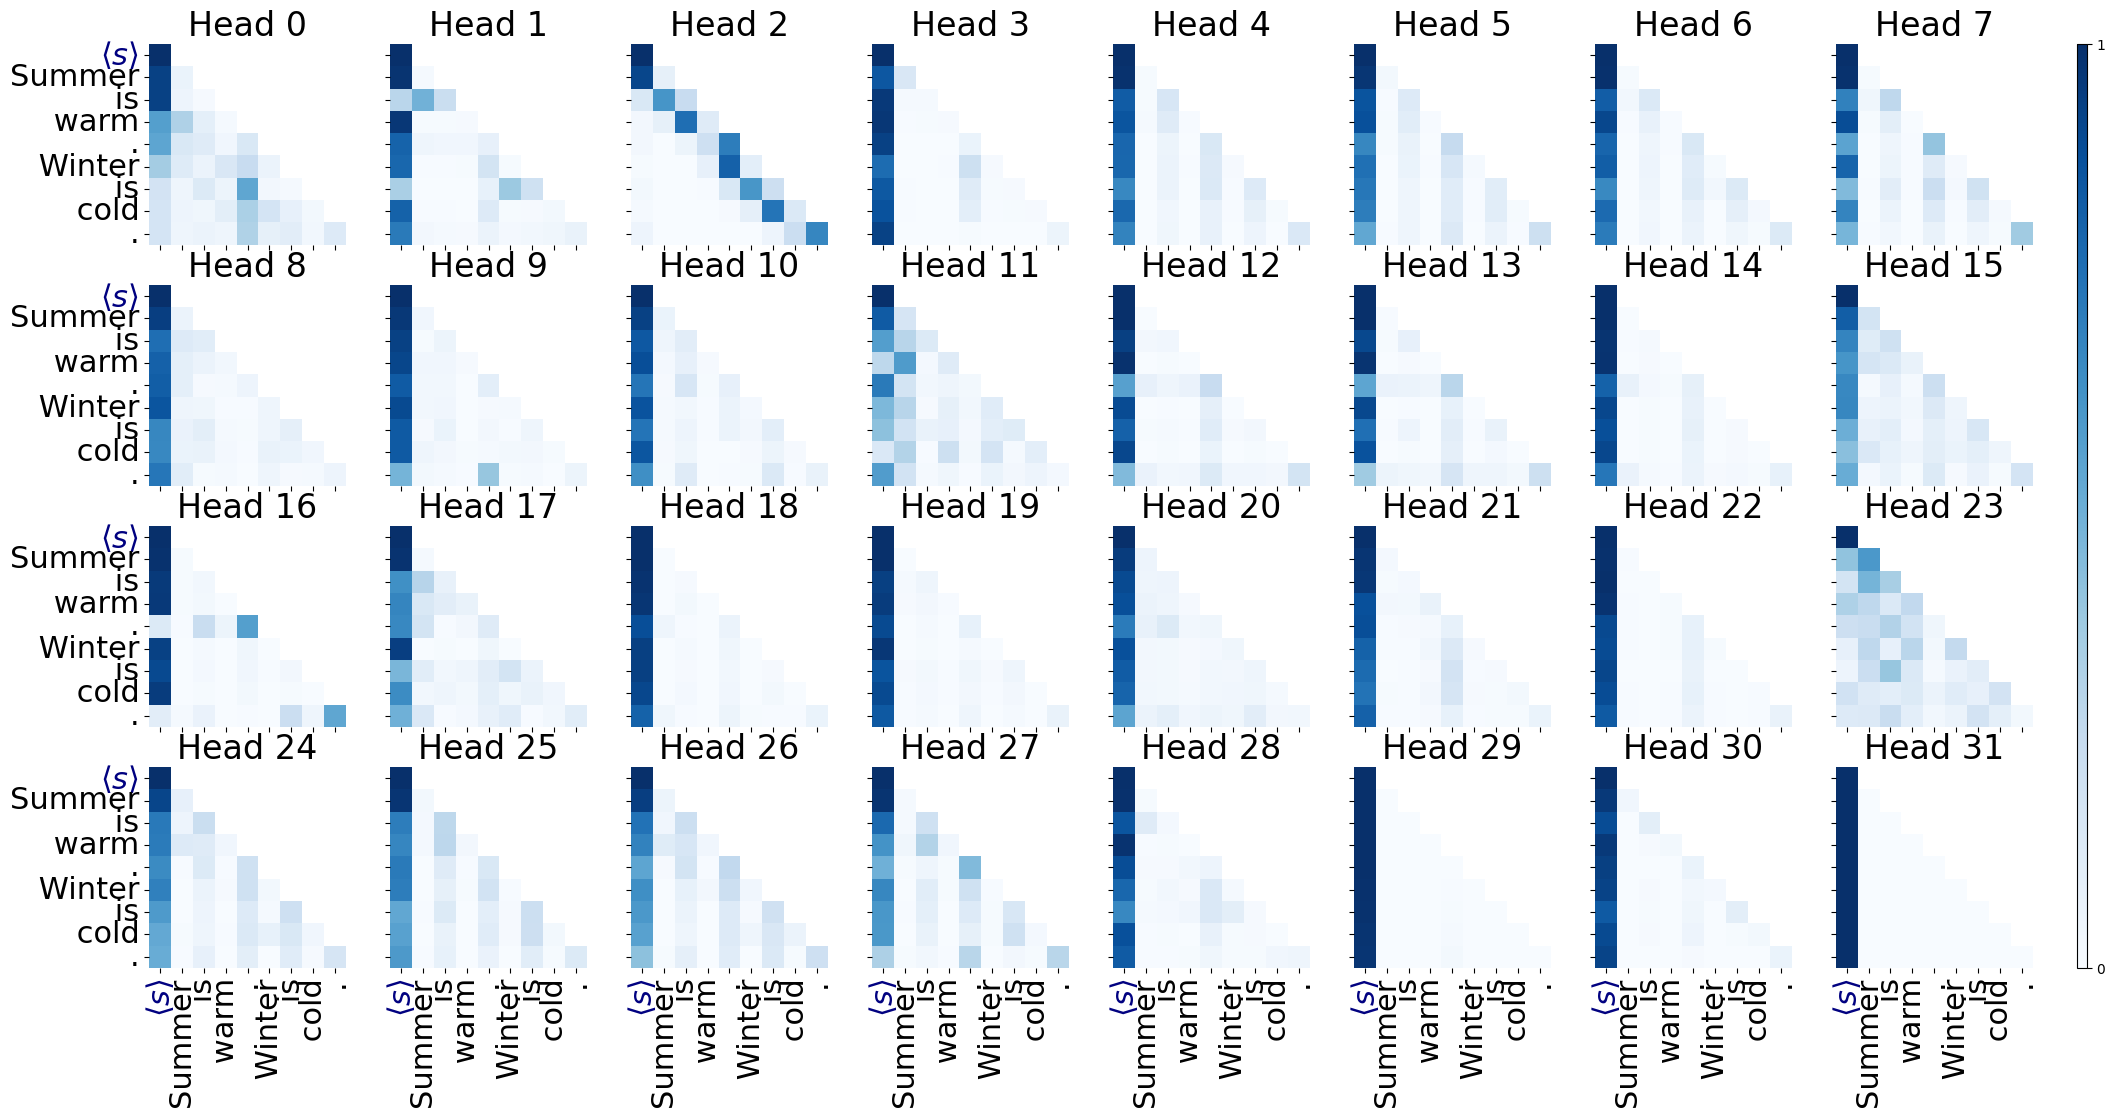

In [17]:
attn_weights = to_numpy(stats["attn_weights"][0])

# heads_to_plot = [19, 29, 31]
heads_to_plot = list(range(32))

fig = plt.figure(figsize=(25, 12))
gs = gridspec.GridSpec(4, 9, width_ratios=[1, 1, 1, 1, 1, 1, 1, 1, 0.05], wspace=0.25)
axes = [fig.add_subplot(gs[i, j]) for i in range(4) for j in range(8)]

for head_idx, ax in zip(heads_to_plot, axes):
    heatmap = sns.heatmap(attn_weights[head_idx], cmap="Blues", ax=ax, mask=attn_weights[head_idx] == 0, vmin=0, vmax=1, cbar=False)
    ax.set_title(f"Head {head_idx}", fontsize=24)
    if head_idx >= 24:
        ax.set_xticklabels(token_labels)
    else:
        ax.set_xticklabels([])
    if head_idx % 8 == 0:
        ax.set_yticklabels(token_labels)
    else:
        ax.set_yticklabels([])
    ax.tick_params(axis='x', labelrotation=90, labelsize=22)
    ax.tick_params(axis='y', labelrotation=0, labelsize=22)

    for xtick, color in zip(ax.get_xticklabels(), token_colors):
        xtick.set_color(color)
    for ytick, color in zip(ax.get_yticklabels(), token_colors):
        ytick.set_color(color)

cbar_ax = fig.add_subplot(gs[:, -1])

norm = colors.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap="Blues", norm=norm)
sm.set_array([])
fig.colorbar(sm, cax=cbar_ax, ticks=[0, 1])

plt.tight_layout()
fig.savefig(os.path.join(dir_path, "demo_attn_heads.pdf"), dpi=300, bbox_inches='tight')
plt.show(fig)



In [18]:
inspect_head = 31

In [19]:
q = stats["q_postrope"]
k = stats["k_postrope"]
v = stats["v_postrope"]
print(q.shape)
print(k.shape)
print(v.shape)


torch.Size([1, 32, 9, 128])
torch.Size([1, 32, 9, 128])
torch.Size([1, 32, 9, 128])


[0.04956055 0.43554688 0.234375   0.39257812 0.078125   0.4609375
 0.234375   0.43164062 0.078125  ]


/tmp/ipykernel_476043/3881325149.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=tokens, y=value_state_norms, palette=token_colors_boxenplot, edgecolor="black")
/tmp/ipykernel_476043/3881325149.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  barplot.set_xticklabels(token_labels)


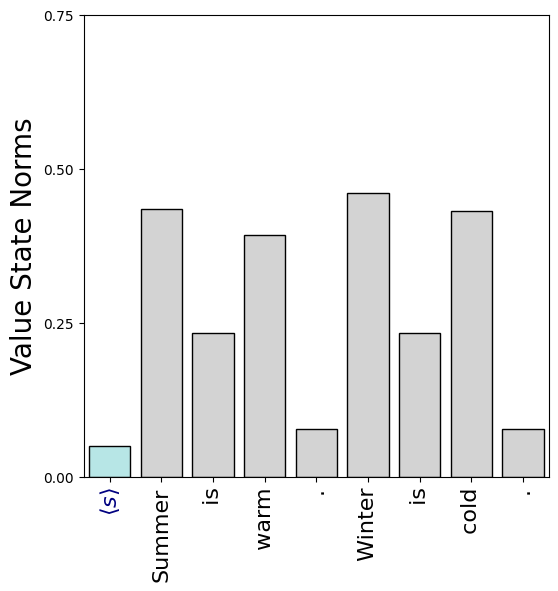

In [20]:
attn = model.model.layers[layer_probe].self_attn
values = stats["v_postrope"]
o_split = attn.o_proj.weight.split(attn.head_dim, dim=1)
vo_head = torch.stack([F.linear(values[0:1, i, ...], o_split[i]) for i in range(num_heads)], dim=1)

value_state_norms = torch.linalg.norm(vo_head, dim=-1)
value_state_norms = to_numpy(value_state_norms[batch_idx, inspect_head])

print(value_state_norms)


plt.figure(figsize=(6, 6))
barplot = sns.barplot(x=tokens, y=value_state_norms, palette=token_colors_boxenplot, edgecolor="black")
barplot.set_xticklabels(token_labels)
barplot.set_yticks([0, 0.25, 0.5, 0.75])

# Set the colors for the x-axis labels
for xtick, color in zip(barplot.get_xticklabels(), token_colors):
    xtick.set_color(color)

plt.setp(barplot.patches, linewidth=1)

# plt.title(f"L{layer_probe}H{inspect_head} " + r"Value State Norms", fontsize=20)
# plt.xlabel('Tokens', fontsize=20)
plt.ylabel('Value State Norms', fontsize=20)
plt.xticks(rotation=90, fontsize=16)
plt.savefig(os.path.join(dir_path, f"demo_val_norms_head_{inspect_head}.pdf"), dpi=300, bbox_inches='tight')
plt.show()


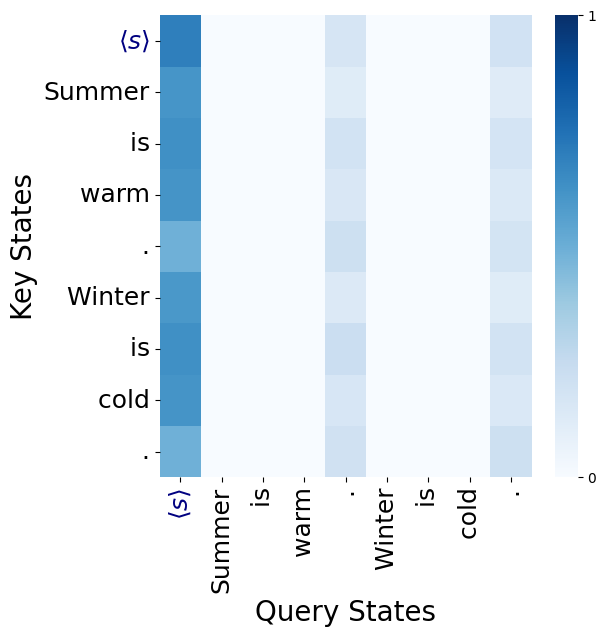

In [47]:
q_normalize = q / torch.linalg.norm(q, dim=-1, keepdim=True)
k_normalize = k / torch.linalg.norm(k, dim=-1, keepdim=True)
qkt = q_normalize @ k_normalize.transpose(2, 3) # (batch, head, q_token, k_token)
qqt = q_normalize @ q_normalize.transpose(2, 3) # (batch, head, k_token, k_token)

qkt = to_numpy(tensor=qkt[batch_idx, inspect_head])
qqt = to_numpy(tensor=qqt[batch_idx, inspect_head])
plt.figure(figsize=(6, 6))
heatmap = sns.heatmap(qkt, cmap="Blues", annot=False, xticklabels=token_labels, yticklabels=token_labels, vmin=0, vmax=1, cbar_kws={'ticks': [0, 1]})
plt.xticks(rotation=90, fontsize=18)
plt.yticks(rotation=0, fontsize=18)

for xtick, color in zip(heatmap.get_xticklabels(), token_colors):
    xtick.set_color(color)

for ytick, color in zip(heatmap.get_yticklabels(), token_colors):
    ytick.set_color(color)
# plt.title(r"$\left\langle \frac{\text{Qry}_{i}}{\|\text{Qry}_{i}\|}, \frac{\text{Key}_{j}}{\|\text{Key}_{j}\|}\right\rangle$", fontsize=24)
plt.xlabel('Query States', fontsize=20)
plt.ylabel('Key States', fontsize=20)
plt.savefig(os.path.join(dir_path, "demo_qkt.pdf"), dpi=300, bbox_inches='tight')
plt.show()

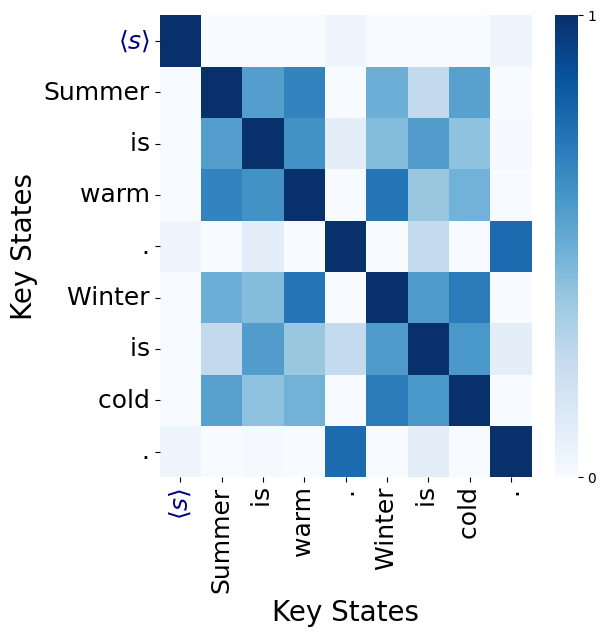

In [22]:
kkt = k_normalize @ k_normalize.transpose(2, 3) # (batch, head, k_token, k_token)

kkt = to_numpy(tensor=kkt[batch_idx, inspect_head])
plt.figure(figsize=(6, 6))
heatmap = sns.heatmap(kkt, cmap="Blues", annot=False, xticklabels=token_labels, yticklabels=token_labels, vmin=0, vmax=1, cbar_kws={'ticks': [0, 1]})
plt.xticks(rotation=90, fontsize=18)
plt.yticks(rotation=0, fontsize=18)

for xtick, color in zip(heatmap.get_xticklabels(), token_colors):
    xtick.set_color(color)

for ytick, color in zip(heatmap.get_yticklabels(), token_colors):
    ytick.set_color(color)
# plt.title(r"$\left\langle \frac{\
# text{Key}_{i}}{\|\text{Key}_{i}\|}, \frac{\text{Key}_{j}}{\|\text{Key}_{j}\|}\right\rangle$", fontsize=24)
plt.xlabel('Key States', fontsize=20)
plt.ylabel('Key States', fontsize=20)
plt.savefig(os.path.join(dir_path, "demo_kkt.pdf"), dpi=300, bbox_inches='tight')
plt.show()

### Step 2: Residual Norms, Where Do They Come From?

In [23]:
from typing import Collection, Dict, Any

class ZeroOutComponentHook(Hook):
	def __init__(self, target_name: str, target_layers: Collection[int]) -> None:
		self.target_layers: Collection[int] = target_layers

		def target_condition(tensor: torch.Tensor, context: Dict[str, Any]) -> bool:
			layer_idx = context.get("layer_idx", -1)
			return layer_idx in self.target_layers

		super().__init__(target_name=target_name, target_condition=target_condition)

	def intervention(
			self, tensor: torch.Tensor, context: Dict[str, Any]
	) -> torch.Tensor:
		return torch.zeros_like(tensor)

In [24]:
layer_probe = 24

layer_record_hook = RecordHook(target_name="post_mlp_residual", record_buffer=[], target_layers=[layer_probe])

In [25]:
wrapper.forward(inputs, layer_record_hook)
original_token_norms = torch.linalg.norm(layer_record_hook.record_buffer[0], dim=-1)
original_bos_token_norm = original_token_norms[batch_idx, 0]

In [26]:
zero_out_l0_attn_hook = ZeroOutComponentHook(target_name="attn_output", target_layers=[0])
wrapper.forward(inputs, CompositeHook(hooks=[zero_out_l0_attn_hook,layer_record_hook]))
ablation_1_token_norms = torch.linalg.norm(layer_record_hook.record_buffer[1], dim=-1)
ablation_1_bos_token_norm = ablation_1_token_norms[batch_idx, 0]

In [27]:
zero_out_l0_mlp_hook = ZeroOutComponentHook(target_name="mlp_down_proj", target_layers=[0])
wrapper.forward(inputs, CompositeHook(hooks=[zero_out_l0_mlp_hook,layer_record_hook]))
ablation_2_token_norms = torch.linalg.norm(layer_record_hook.record_buffer[2], dim=-1)
ablation_2_bos_token_norm = ablation_2_token_norms[batch_idx, 0]


In [28]:
wrapper.forward(inputs, CompositeHook(hooks=[zero_out_l0_attn_hook, zero_out_l0_mlp_hook,layer_record_hook]))
ablation_3_token_norms = torch.linalg.norm(layer_record_hook.record_buffer[3], dim=-1)
ablation_3_bos_token_norm = ablation_3_token_norms[batch_idx, 0]

In [29]:
zero_out_l1_attn_hook = ZeroOutComponentHook(target_name="attn_output", target_layers=[1])
wrapper.forward(inputs, CompositeHook(hooks=[zero_out_l1_attn_hook,layer_record_hook]))
ablation_4_token_norms = torch.linalg.norm(layer_record_hook.record_buffer[4], dim=-1)
ablation_4_bos_token_norm = ablation_4_token_norms[batch_idx, 0]

In [30]:
zero_out_l1_mlp_hook = ZeroOutComponentHook(target_name="mlp_down_proj", target_layers=[1])
wrapper.forward(inputs, CompositeHook(hooks=[zero_out_l1_mlp_hook,layer_record_hook]))
ablation_5_token_norms = torch.linalg.norm(layer_record_hook.record_buffer[5], dim=-1)
ablation_5_bos_token_norm = ablation_5_token_norms[batch_idx, 0]

In [31]:

wrapper.forward(inputs, CompositeHook(hooks=[zero_out_l1_attn_hook, zero_out_l1_mlp_hook,layer_record_hook]))
ablation_6_token_norms = torch.linalg.norm(layer_record_hook.record_buffer[6], dim=-1)
ablation_6_bos_token_norm = ablation_6_token_norms[batch_idx, 0]


In [32]:

wrapper.forward(inputs, CompositeHook(hooks=[zero_out_l0_attn_hook, zero_out_l0_mlp_hook, zero_out_l1_attn_hook, zero_out_l1_mlp_hook,layer_record_hook]))
ablation_7_token_norms = torch.linalg.norm(layer_record_hook.record_buffer[7], dim=-1)
ablation_7_bos_token_norm = ablation_7_token_norms[batch_idx, 0]



In [33]:
zero_out_l2_attn_hook = ZeroOutComponentHook(target_name="attn_output", target_layers=[2])
wrapper.forward(inputs, CompositeHook(hooks=[zero_out_l2_attn_hook,layer_record_hook]))
ablation_8_token_norms = torch.linalg.norm(layer_record_hook.record_buffer[8], dim=-1)
ablation_8_bos_token_norm = ablation_8_token_norms[batch_idx, 0]

In [34]:
zero_out_l2_mlp_hook = ZeroOutComponentHook(target_name="mlp_down_proj", target_layers=[2])
wrapper.forward(inputs, CompositeHook(hooks=[zero_out_l2_mlp_hook,layer_record_hook]))
ablation_9_token_norms = torch.linalg.norm(layer_record_hook.record_buffer[9], dim=-1)
ablation_9_bos_token_norm = ablation_9_token_norms[batch_idx, 0]


In [35]:
wrapper.forward(inputs, CompositeHook(hooks=[zero_out_l2_attn_hook, zero_out_l2_mlp_hook,layer_record_hook]))
ablation_10_token_norms = torch.linalg.norm(layer_record_hook.record_buffer[10], dim=-1)
ablation_10_bos_token_norm = ablation_10_token_norms[batch_idx, 0]

In [36]:
wrapper.forward(inputs, CompositeHook(hooks=[zero_out_l0_attn_hook, zero_out_l0_mlp_hook, zero_out_l1_attn_hook, zero_out_l1_mlp_hook, zero_out_l2_attn_hook, zero_out_l2_mlp_hook,layer_record_hook]))
ablation_11_token_norms = torch.linalg.norm(layer_record_hook.record_buffer[11], dim=-1)
ablation_11_bos_token_norm = ablation_11_token_norms[batch_idx, 0]

In [37]:

print(f"Original: {original_bos_token_norm}")
print(f"Ablation 1: {ablation_1_bos_token_norm}")
print(f"Ablation 2: {ablation_2_bos_token_norm}")
print(f"Ablation 3: {ablation_3_bos_token_norm}")
print(f"Ablation 4: {ablation_4_bos_token_norm}")
print(f"Ablation 5: {ablation_5_bos_token_norm}")
print(f"Ablation 6: {ablation_6_bos_token_norm}")
print(f"Ablation 7: {ablation_7_bos_token_norm}")
print(f"Ablation 8: {ablation_8_bos_token_norm}")
print(f"Ablation 9: {ablation_9_bos_token_norm}")
print(f"Ablation 10: {ablation_10_bos_token_norm}")
print(f"Ablation 11: {ablation_11_bos_token_norm}")


Original: 496.0
Ablation 1: 500.0
Ablation 2: 34.25
Ablation 3: 56.75
Ablation 4: 500.0
Ablation 5: 26.875
Ablation 6: 26.75
Ablation 7: 30.25
Ablation 8: 496.0
Ablation 9: 496.0
Ablation 10: 496.0
Ablation 11: 30.125


In [38]:
print("Original: ", original_token_norms.topk(k=2).values)
print("Ablation 1: ", ablation_1_token_norms.topk(k=2).values)
print("Ablation 2: ", ablation_2_token_norms.topk(k=2).values)
print("Ablation 3: ", ablation_3_token_norms.topk(k=2).values)
print("Ablation 4: ", ablation_4_token_norms.topk(k=2).values)
print("Ablation 5: ", ablation_5_token_norms.topk(k=2).values)
print("Ablation 6: ", ablation_6_token_norms.topk(k=2).values)
print("Ablation 7: ", ablation_7_token_norms.topk(k=2).values)
print("Ablation 8: ", ablation_8_token_norms.topk(k=2).values)
print("Ablation 9: ", ablation_9_token_norms.topk(k=2).values)
print("Ablation 10: ", ablation_10_token_norms.topk(k=2).values)
print("Ablation 11: ", ablation_11_token_norms.topk(k=2).values)


Original:  tensor([[496.,  37.]], device='cuda:0', dtype=torch.bfloat16)
Ablation 1:  tensor([[500.,  30.]], device='cuda:0', dtype=torch.bfloat16)
Ablation 2:  tensor([[34.2500, 34.2500]], device='cuda:0', dtype=torch.bfloat16)
Ablation 3:  tensor([[56.7500, 31.5000]], device='cuda:0', dtype=torch.bfloat16)
Ablation 4:  tensor([[500.0000,  37.2500]], device='cuda:0', dtype=torch.bfloat16)
Ablation 5:  tensor([[32.5000, 32.5000]], device='cuda:0', dtype=torch.bfloat16)
Ablation 6:  tensor([[32.2500, 31.7500]], device='cuda:0', dtype=torch.bfloat16)
Ablation 7:  tensor([[30.2500, 29.0000]], device='cuda:0', dtype=torch.bfloat16)
Ablation 8:  tensor([[496.0000,  36.7500]], device='cuda:0', dtype=torch.bfloat16)
Ablation 9:  tensor([[496.0000,  36.7500]], device='cuda:0', dtype=torch.bfloat16)
Ablation 10:  tensor([[496.0000,  36.7500]], device='cuda:0', dtype=torch.bfloat16)
Ablation 11:  tensor([[30.1250, 29.6250]], device='cuda:0', dtype=torch.bfloat16)


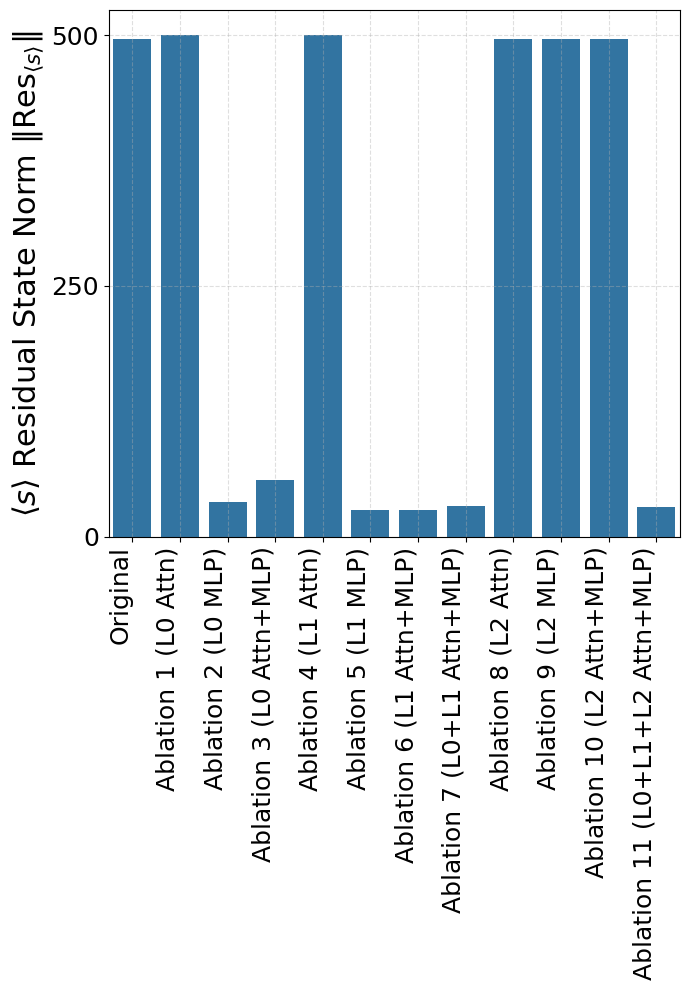

In [39]:

# Data for plotting
ablations = [
    to_numpy(tensor=original_bos_token_norm).item(),
    to_numpy(tensor=ablation_1_bos_token_norm).item(),
    to_numpy(tensor=ablation_2_bos_token_norm).item(),
    to_numpy(tensor=ablation_3_bos_token_norm).item(),
    to_numpy(tensor=ablation_4_bos_token_norm).item(),
    to_numpy(tensor=ablation_5_bos_token_norm).item(),
    to_numpy(tensor=ablation_6_bos_token_norm).item(),
    to_numpy(tensor=ablation_7_bos_token_norm).item(),
    to_numpy(tensor=ablation_8_bos_token_norm).item(),
    to_numpy(tensor=ablation_9_bos_token_norm).item(),
    to_numpy(tensor=ablation_10_bos_token_norm).item(),
    to_numpy(tensor=ablation_11_bos_token_norm).item()
]

labels = [
    "Original",
    "Ablation 1 (L0 Attn)",
    "Ablation 2 (L0 MLP)",
    "Ablation 3 (L0 Attn+MLP)",
    "Ablation 4 (L1 Attn)",
    "Ablation 5 (L1 MLP)",
    "Ablation 6 (L1 Attn+MLP)",
    "Ablation 7 (L0+L1 Attn+MLP)",
    "Ablation 8 (L2 Attn)",
    "Ablation 9 (L2 MLP)",
    "Ablation 10 (L2 Attn+MLP)",
    "Ablation 11 (L0+L1+L2 Attn+MLP)"
]

# Create the barplot
plt.figure(figsize=(7, 10))
sns.barplot(x=labels, y=ablations)
plt.grid(alpha=0.4, linestyle='--')
#plt.title(f"Layer {layer_probe} " + "<s> Token Norms Ablation Study", fontsize=20)
#plt.xlabel("Ablation Type", fontsize=16)
plt.ylabel(r"$\langle s\rangle$ Residual State Norm $\|" + r"\text{Res}_{\langle s \rangle}" + r"\|$", fontsize=22)
plt.xticks(rotation=90, ha="right", fontsize=18)
plt.yticks([0, 250, 500], fontsize=18)
plt.tight_layout()
plt.savefig( os.path.join(dir_path, "res_intervention.pdf"), dpi=300, bbox_inches='tight')

plt.show()


In [40]:
from src.dataset import load_data_batches, load_dataset_from_hf
import json

# data_batches = load_data_batches("wikipedia", batch_size=128, num_batches=1, filter_function=lambda x: len(x["text"]) > 100)
dataset_name = "wikipedia"
with open("/data/tianyu/massive-unlearning/dataset/RedPajama/wiki_texts.json") as f:
    batch = json.load(f)
data_batch = batch[0]

In [41]:
inputs_batch = tokenizer(batch, return_tensors="pt", truncation=True, max_length=9).input_ids.to(device)
inputs = tokenizer(data_batch, return_tensors="pt", truncation=True, max_length=9).input_ids.to(device)

/tmp/ipykernel_476043/4206975282.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxenplot = sns.boxenplot(x="Token", y="Weights", data=df, palette=token_colors_boxenplot, showfliers=True, flier_kws=dict(marker='v', c='black', s=6,), linewidth=1.5)


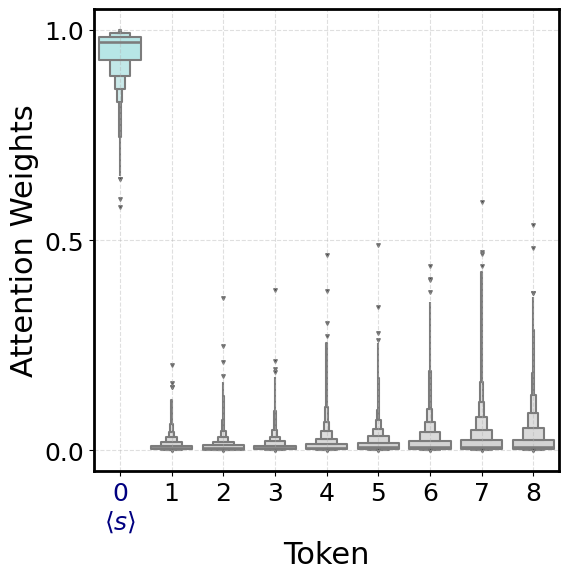

In [42]:
stats = collect_statistics(inputs_batch[:128], layer_probe)
attn_weights = stats["attn_weights"]

avg_attn_weights_on_k_tokens = torch.sum(attn_weights, dim=-2) / torch.sum(attn_weights != 0, dim=-2)

attn_weights_on_bos = avg_attn_weights_on_k_tokens[:, :, 0]
max_attn_weights_on_non_bos = torch.max(avg_attn_weights_on_k_tokens[:, :, 1:], dim=-1).values

df = pd.DataFrame(
    {
        "Token": list(range(attn_weights.shape[-1])), 
        "Weights": list(to_numpy(tensor=avg_attn_weights_on_k_tokens[..., i].flatten()).tolist() for i in range(attn_weights.shape[-1]))
    }
).explode("Weights")
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.grid(alpha=0.4, linestyle='--')
for x in ax.spines.values():
    x.set_linewidth(2)

boxenplot = sns.boxenplot(x="Token", y="Weights", data=df, palette=token_colors_boxenplot, showfliers=True, flier_kws=dict(marker='v', c='black', s=6,), linewidth=1.5)
plt.grid(alpha=0.4, linestyle='--')
plt.ylabel("Attention Weights", fontsize=22)
plt.xlabel("Token", fontsize=22)
plt.xticks(ticks=list(range(attn_weights.shape[-1])), labels=['0\n'+r'$\langle s\rangle$'] + list(range(1, attn_weights.shape[-1])), fontsize=18)
plt.yticks([0, 0.5, 1], fontsize=18)


for xtick, color in zip(boxenplot.get_xticklabels(), token_colors):
    xtick.set_color(color)
plt.savefig( os.path.join(dir_path, "attn_weights_batch.pdf"), dpi=300, bbox_inches='tight')
plt.show(fig)


In [43]:
layerwise_value_state_norms = []
layerwise_token_norms = []
for layer in range(num_layers):
    stats = collect_statistics(inputs_batch[:128], layer)
    attn = model.model.layers[layer_probe].self_attn
    values = stats["v_postrope"]
    o_split = attn.o_proj.weight.split(attn.head_dim, dim=1)
    vo_head = torch.stack([F.linear(values[:, i, ...], o_split[i]) for i in range(num_heads)], dim=1)
    layerwise_value_state_norms.append(torch.linalg.norm(vo_head, dim=-1))  # (B, H, N)
    layerwise_token_norms.append(torch.linalg.norm(stats["post_mlp_residual"], dim=-1))
layerwise_token_norms = torch.stack(layerwise_token_norms, dim=0)  # (L, B, N)
layerwise_bos_norms = layerwise_token_norms[:, :, 0]  # (L, B)
layerwise_value_state_norms = torch.stack(layerwise_value_state_norms, dim=0)  # (L, B, H, N)



/tmp/ipykernel_476043/840283961.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxenplot = sns.boxenplot(data=df, x="Token", y="Value State Norms", palette=token_colors_boxenplot, showfliers=True, flier_kws=dict(marker='v', c='black', s=6,), linewidth=1.5)


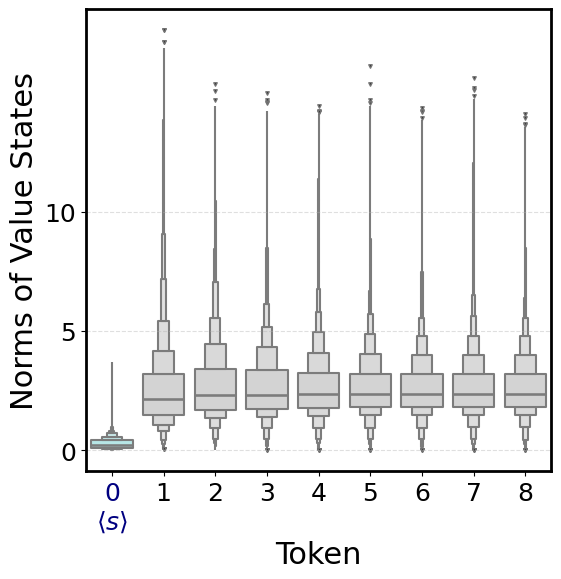

In [49]:

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.grid(alpha=0.4, linestyle='--')
for x in ax.spines.values():
    x.set_linewidth(2)

value_state_norms = to_numpy(tensor=layerwise_value_state_norms.transpose(0, 3).flatten(1, 3))  # (N, B * H * L)
df = pd.DataFrame({"Token": list(range(value_state_norms.shape[0])), "Value State Norms": value_state_norms.tolist()}).explode("Value State Norms")

boxenplot = sns.boxenplot(data=df, x="Token", y="Value State Norms", palette=token_colors_boxenplot, showfliers=True, flier_kws=dict(marker='v', c='black', s=6,), linewidth=1.5)
boxenplot.set_xticks(range(len(token_labels)))
plt.xticks(fontsize=18)
plt.yticks([0, 5, 10], fontsize=18)
boxenplot.set_xticklabels(['0\n'+r"$\langle s \rangle$"] + list(range(1, len(token_labels))))

for xtick, color in zip(boxenplot.get_xticklabels(), token_colors):
    xtick.set_color(color)
plt.xlabel("Token", fontsize=22)
plt.ylabel('Norms of Value States', fontsize=22)
# plt.yscale("log")
plt.savefig(os.path.join(dir_path, "val_drain_batch.pdf"), dpi=300, bbox_inches='tight')
plt.show(fig)
torch.cuda.empty_cache()

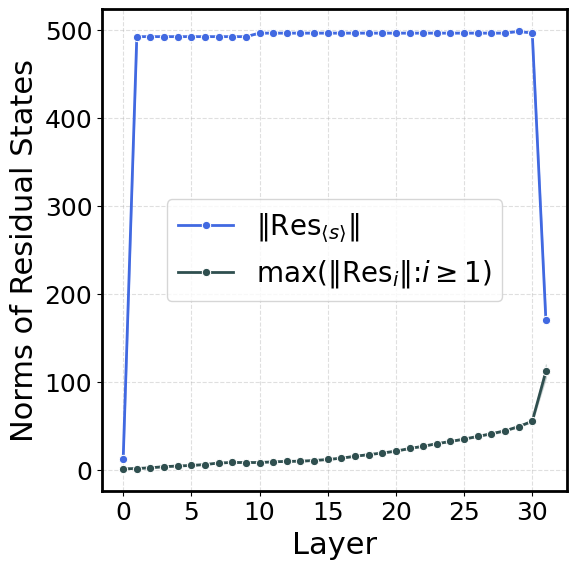

In [45]:
fig = plt.figure(figsize=(6, 6.25))
ax = fig.add_subplot(1, 1, 1)
ax.grid(alpha=0.4, linestyle='--')
for x in ax.spines.values():
    x.set_linewidth(2)

df = pd.DataFrame({"Layer": list(range(num_layers)), "Norm": to_numpy(tensor=layerwise_bos_norms).tolist()}).explode("Norm")
sns.lineplot(x="Layer", y="Norm", data=df, label=r"$\|$" + r"$\text{Res}_{{\langle s\rangle}}$" + r"$\|$", marker="o", color=token_colors_plots[0], linewidth=2)

layerwise_max_non_bos_norms = torch.max(layerwise_token_norms[:, :, 1:], dim=-1).values

df = pd.DataFrame({"Layer": list(range(num_layers)), "Norm": to_numpy(tensor=layerwise_max_non_bos_norms).tolist()}).explode("Norm")
sns.lineplot(x="Layer", y="Norm", data=df, label=r"$\max(\|" + r"\text{Res}_{i}" + r"\| \colon i \geq 1)$", marker="o", color=token_colors_plots[1], linewidth=2)

plt.ylabel("Norms of Residual States", fontsize=22)
plt.xlabel("Layer", fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# #plt.title("Residual Stream Token Norms", fontsize=20)
plt.legend(fontsize=20)
plt.savefig(os.path.join(dir_path, "res_peak_batch.pdf"), dpi=300, bbox_inches='tight')
plt.show()
